In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


## Collect data into df

In [ ]:
def create_dataframe():
    # initialize db connection and session
    db_engine, db_session = init_db()

    # query data from the database
    query = db_session.query(
        RacingWeekend.year,
        RacingWeekend.round,
        Circuit.circuit_name,
        Driver.driver_name,
        Driver.driver_short,
        Lap.lap_num,
        Lap.lap_time,
        Lap.tyre,
        Lap.tyre_laps,
        Lap.pit,
        Session.session_type
    ).join(RacingWeekend.circuit) \
     .join(RacingWeekend.sessions) \
     .join(Session.laps) \
     .join(Lap.driver) \
     .join(RacingWeekend.season) \
     .all()

    # convert result to list of dicts
    data = []
    for row in query:
        data.append({
            'year': row.year,
            'round': row.round,
            'circuit_name': row.circuit_name,
            'driver_name': row.driver_name,
            'driver_short': row.driver_short,
            'lap_num': row.lap_num,
            'lap_time': row.lap_time,
            'tyre': row.tyre,
            'tyre_laps': row.tyre_laps,
            'pit': row.pit,
            'session_type': row.session_type
        })

    # create dataframe
    df = pd.DataFrame(data)


    return df

# create the dataframe and print it
df = create_dataframe()

print(df.columns.tolist())




['year', 'round', 'circuit_name', 'driver_name', 'driver_short', 'lap_num', 'lap_time', 'tyre', 'tyre_laps', 'pit', 'session_type']


### Calc tyre deg

So here i want to look at the practice sessions for a weekend, look at long runs for a car, then find out tyre deg

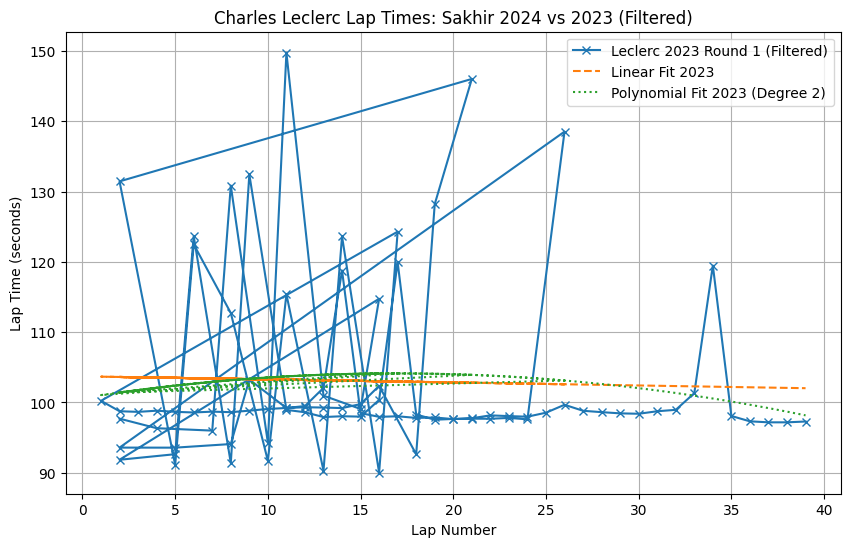

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_leclerc_lap_times(df, year_1, round_1):
    # Filter the 2023 race, Round 1, for the circuit and Charles Leclerc
    race_2023 = df[(df['year'] == year_1) & (df['round'] == round_1) & (df['driver_short'] == 'LEC')]
    
    # Get the circuit name from the 2023 race
    circuit_name = race_2023['circuit_name'].iloc[0]
    
    # Calculate the previous year dynamically
    year_2 = year_1 - 1
    
    # Filter the 2022 race on the same circuit for Charles Leclerc
    race_2022 = df[(df['year'] == year_2) & (df['circuit_name'] == circuit_name) & (df['driver_short'] == 'LEC')]
    
    # Find the fastest lap in 2023
    fastest_lap_2023 = race_2023['lap_time'].astype(float).min()
    
    # Calculate the 20% longer lap time threshold
    threshold_2023 = fastest_lap_2023 * 1.2  # Adjust threshold if necessary
    
    # Filter out laps that are 20% longer than the fastest lap in 2023
    race_2023_filtered = race_2023[race_2023['lap_time'].astype(float) <= threshold_2023]
    
    # Find the fastest lap in 2022
    fastest_lap_2022 = race_2022['lap_time'].astype(float).min()
    
    # Calculate the 20% longer lap time threshold for 2022
    threshold_2022 = fastest_lap_2022 * 1.9
    
    # Filter out laps that are 20% longer than the fastest lap in 2022
    race_2022_filtered = race_2022[race_2022['lap_time'].astype(float) <= threshold_2022]
    
    # Plot the filtered lap times against lap numbers for both years
    plt.figure(figsize=(10, 6))
    


    # Plot 2022 filtered lap times
    plt.plot(race_2022_filtered['lap_num'], race_2022_filtered['lap_time'].astype(float), 
             label=f'Leclerc {year_2} Round {round_1} (Filtered)', marker='x')

    # Linear Fit for 2022
    linear_coeffs_2022 = np.polyfit(race_2022_filtered['lap_num'], race_2022_filtered['lap_time'].astype(float), 1)
    linear_fit_2022 = np.poly1d(linear_coeffs_2022)
    plt.plot(race_2022_filtered['lap_num'], linear_fit_2022(race_2022_filtered['lap_num']), 
             label=f'Linear Fit {year_2}', linestyle='--')

    # Polynomial Fit (degree 2) for 2022
    poly_coeffs_2022 = np.polyfit(race_2022_filtered['lap_num'], race_2022_filtered['lap_time'].astype(float), 2)
    poly_fit_2022 = np.poly1d(poly_coeffs_2022)
    plt.plot(race_2022_filtered['lap_num'], poly_fit_2022(race_2022_filtered['lap_num']), 
             label=f'Polynomial Fit {year_2} (Degree 2)', linestyle=':')

    # Add labels and title
    plt.xlabel('Lap Number')
    plt.ylabel('Lap Time (seconds)')
    plt.title(f'Charles Leclerc Lap Times: {circuit_name} {year_1} vs {year_2} (Filtered)')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Example usage: plot Leclerc's lap times for 2023 and the year before (2022), filtering laps 20% slower
plot_leclerc_lap_times(df, 2024, 1)


1. Average through last season (or maybe last x races) for each driver, if driver wasnt in last season, then average of all (or maybe same car in previous year?)
1. Look at practice and just try and get something from it, but not a lot of long runs
1. Just set an absolute value no matter what, maybe i just look into it now and set the value
1. 

/tmp/ipykernel_33664/1225075757.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['lap_time'] = df_filtered['lap_time'].astype(float)


Mean Squared Error: 35.68520016820696


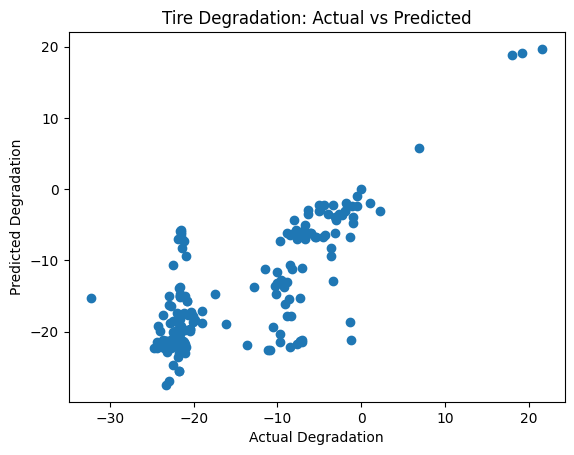

     feature  importance
0    lap_num    0.685958
1  tyre_laps    0.194032
2        pit    0.120010


In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def create_dataframe():
    # Initialize db connection and session
    db_engine, db_session = init_db()

    # Query data from the database
    query = db_session.query(
        RacingWeekend.year,
        RacingWeekend.round,
        Circuit.circuit_name,
        Driver.driver_name,
        Driver.driver_short,
        Lap.lap_num,
        Lap.lap_time,
        Lap.tyre,
        Lap.tyre_laps,
        Lap.pit,
        Session.session_type
    ).join(RacingWeekend.circuit) \
     .join(RacingWeekend.sessions) \
     .join(Session.laps) \
     .join(Lap.driver) \
     .join(RacingWeekend.season) \
     .all()

    # Convert result to list of dicts
    data = []
    for row in query:
        data.append({
            'year': row.year,
            'round': row.round,
            'circuit_name': row.circuit_name,
            'driver_name': row.driver_name,
            'driver_short': row.driver_short,
            'lap_num': row.lap_num,
            'lap_time': row.lap_time,
            'tyre': row.tyre,
            'tyre_laps': row.tyre_laps,
            'pit': row.pit,
            'session_type': row.session_type
        })

    # Create dataframe
    df = pd.DataFrame(data)
    return df

# Load data
df = create_dataframe()

# Filter for the specific race session ("Race" for Round 1, 2023)
df_filtered = df[(df['year'] == 2023) & (df['round'] == 1) & (df['session_type'] == 'Race')]

# Convert lap_time to float (assuming lap_time is in a string format)
df_filtered['lap_time'] = df_filtered['lap_time'].astype(float)

# Calculate tire degradation (difference between lap time and the first lap of the stint)
# We assume the first lap is the reference lap and track degradation over time
df_filtered = df_filtered.sort_values(by=['driver_short', 'lap_num'])

# Identify the first lap for each tire stint and calculate degradation
df_filtered['initial_lap_time'] = df_filtered.groupby(['driver_short', 'tyre'])['lap_time'].transform('first')
df_filtered['degradation'] = df_filtered['lap_time'] - df_filtered['initial_lap_time']

# Filter out laps where tire laps is less than 3 (exclude the first few laps where degradation might not be significant)
df_filtered = df_filtered[df_filtered['tyre_laps'] > 3]

# Features for the model
features = ['lap_num', 'tyre_laps', 'pit']
X = df_filtered[features]

# Target variable: tire degradation
y = df_filtered['degradation']

# One-hot encode the tire type (tyre)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict the tire degradation on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot predicted vs actual degradation
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Degradation')
plt.ylabel('Predicted Degradation')
plt.title('Tire Degradation: Actual vs Predicted')
plt.show()

# Feature importances
importances = model.feature_importances_
features_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(features_importance_df)
